**Approved drugs from the ChEMBL database**

Inspired by: youtube.com/c/DataProfessor

**Import libraries**

In [1]:
import mols2grid
import numpy as np
import pandas as pd
from chembl_webresource_client.new_client import new_client
from plotnine import *
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.Descriptors import ExactMolWt


**See available data entities**

In [2]:
available_resources = [resource for resource in dir(new_client) if not resource.startswith("_")]
print(available_resources)

['activity', 'activity_supplementary_data_by_activity', 'assay', 'assay_class', 'atc_class', 'binding_site', 'biotherapeutic', 'cell_line', 'chembl_id_lookup', 'compound_record', 'compound_structural_alert', 'description', 'document', 'document_similarity', 'drug', 'drug_indication', 'drug_warning', 'go_slim', 'image', 'mechanism', 'metabolism', 'molecule', 'molecule_form', 'official', 'organism', 'protein_class', 'similarity', 'source', 'substructure', 'target', 'target_component', 'target_relation', 'tissue', 'xref_source']


**Filter drugs by approval year**

In [3]:
# get all the drugs approved (phase IV) since 2000
start_year = 2000
clinical_phase = 4

molecule = new_client.molecule
by = "molecule_properties__mw_freebase"
res = molecule.filter(first_approval__gte=start_year,
                      max_phase=clinical_phase).order_by(by)
df = pd.DataFrame.from_dict(res)
df = df.sort_values(by="first_approval")
df.head()

,atc_classifications,availability_type,biotherapeutic,black_box_warning,chebi_par_id,chirality,cross_references,dosed_ingredient,first_approval,first_in_class,...,topical,usan_stem,usan_stem_definition,usan_substem,usan_year,withdrawn_class,withdrawn_country,withdrawn_flag,withdrawn_reason,withdrawn_year
346,[A02BC02],1,None,0,7915.0,0,"[{'xref_id': 'pantoprazole%20sodium', 'xref_na...",True,2000,0,...,False,-prazole,antiulcer agents (benzimidazole derivatives),-prazole,1991.0,None,None,False,None,NaN
74,[N03AX15],1,None,0,10127.0,0,"[{'xref_id': 'zonisamide', 'xref_name': 'zonis...",True,2000,0,...,False,None,None,None,1985.0,None,None,False,None,NaN
235,[A10BX03],1,None,0,31897.0,1,"[{'xref_id': 'nateglinide', 'xref_name': 'nate...",True,2000,0,...,False,-glinide,"antidiabetic, SGLT2 inhibitors, not phlorozin ...",-glinide,2000.0,None,None,False,None,NaN
69,[N07AX03],1,None,0,NaN,0,"[{'xref_id': 'cevimeline%20hydrochloride', 'xr...",False,2000,0,...,False,-meline,cholinergic agonists (arecoline derivatives us...,-meline,1997.0,None,None,False,None,NaN
68,[],1,None,0,NaN,0,"[{'xref_id': 'cevimeline%20hydrochloride', 'xr...",True,2000,0,...,False,-meline,cholinergic agonists (arecoline derivatives us...,-meline,1997.0,None,None,False,None,NaN


**Count the approved drugs/biotherapeutics per year**

In [4]:
df_ = df.melt(id_vars="biotherapeutic", value_vars="first_approval")
df_["biotherapeutic"] = df_["biotherapeutic"].apply(lambda x: x is not None)
df_.head()

,biotherapeutic,variable,value
0,False,first_approval,2000
1,False,first_approval,2000
2,False,first_approval,2000
3,False,first_approval,2000
4,False,first_approval,2000


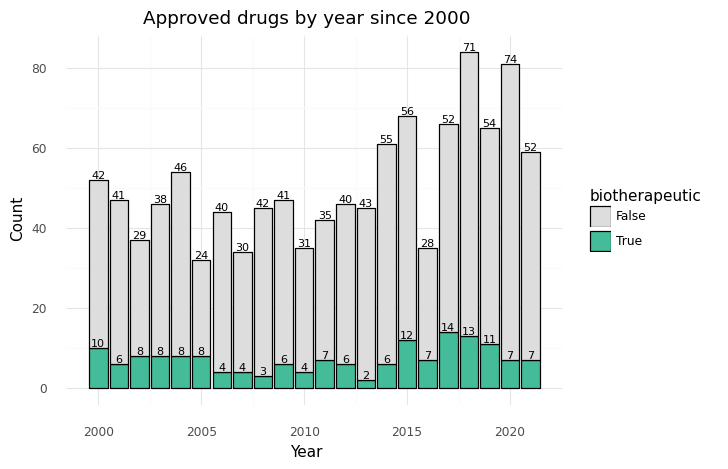

<ggplot: (-9223371885039868484)>

In [5]:
p4 = (
      ggplot(data=df_, mapping=aes("value", fill="biotherapeutic"))
      + geom_bar(stat="count", colour="black")
      + geom_text(
            aes(label=after_stat("count")),
            stat="count",
            position=position_stack(vjust=1.0), size=8,
            va="bottom")
      + scale_fill_manual(values=["#DDDDDD","#44BB99"])
      + theme_minimal()
      + ggtitle("Approved drugs by year since 2000")
      + ylab("Count")
      + xlab("Year")
)
p4

**Utility functions**

In [6]:
def to_canonical_smile(x):
      """ Get canonical smile for molecule structures """
      return np.nan if pd.isna(x) else x["canonical_smiles"]

def to_name(x):
      """ Get name of the compound from molecule synonyms """
      return np.nan if not x else x[0]["molecule_synonym"]

def to_mw(x):
      """ Get molecular weight from smile """
      mol = Chem.MolFromSmiles(x)
      return round(ExactMolWt(mol), 2)

In [7]:
df["smiles"] = df["molecule_structures"].apply(to_canonical_smile)
df["name"] = df["molecule_synonyms"].apply(to_name)

**Approved drugs in 2020**

In [8]:
# First drop rows where no canonical smile or commercial name is available
df.dropna(subset=["smiles", "name"], inplace=True)

# select 2020 approved drugs
sel_year = 2020
df_2020 = df[["name", "smiles", "biotherapeutic"]][df["first_approval"] == sel_year]

**Get molecular weights**

In [9]:
df_2020["mw"] = df_2020["smiles"].apply(to_mw)
df_2020.head()

,name,smiles,biotherapeutic,mw
814,Lurbinectedin,COc1ccc2[nH]c3c(c2c1)CCN[C@]31CS[C@@H]2c3c(OC(...,None,784.28
21,Magnesium oxybate,O=C([O-])CCCO.O=C([O-])CCCO.[Mg+2],None,230.06
323,Aminosultopride,CCN1CCCC1CNC(=O)c1cc(S(=O)(=O)CC)c(N)cc1OC,None,369.17
640,Dcc-2618,CCn1c(=O)c(-c2cc(NC(=O)Nc3ccccc3)c(F)cc2Br)cc2...,None,509.09
754,Orgovyx,CONC(=O)Nc1ccc(-c2sc3c(c2CN(C)C)c(=O)n(-c2ccc(...,None,623.18


**Represent found molecules using mols2grid**

Highlight biotherapeutics

In [10]:
grid = mols2grid.MolGrid(df_2020, smiles_col="smiles",
                         name="Approved drugs in 2020",
                         use_coords=True,
                         fixedBondLength=25)

grid.display(subset=["img", "name", "mw"],
             tooltip=["name", "mw", "biotherapeutic"],
             style={"biotherapeutic": lambda x: "color: green; font-weight: bold;" if pd.notna(x) else "",
                    "__all__": lambda x: "background-color: honeydew;" if pd.notna(x["biotherapeutic"]) else ""
                    })

**For some reasons, mols2grid is not displayed on online notebooks**

So, display 2D depictions of a subset (9) of these molecules using the default RDKit function Draw.MolsToGridImage

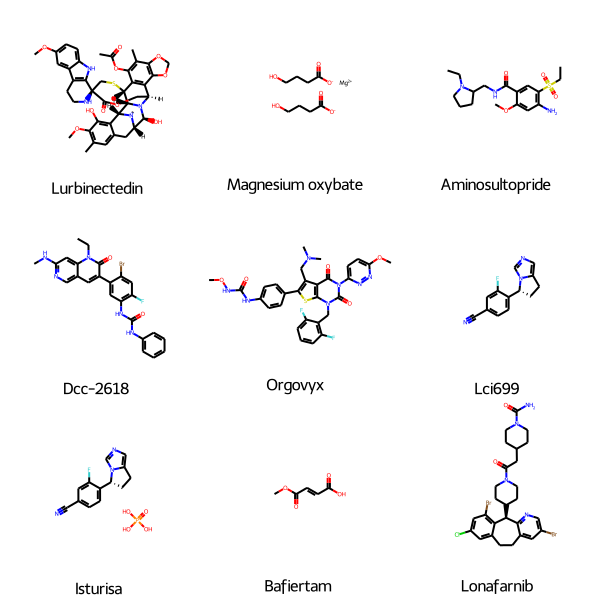

In [11]:
n_mols = 9

mols = df_2020["smiles"][:n_mols].apply(Chem.MolFromSmiles)
legend = [*df_2020["name"]][:n_mols]
mols.apply(AllChem.Compute2DCoords)

Draw.MolsToGridImage(mols, molsPerRow=3, legends=legend)